In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import os

In [16]:
# Load the data
banks = pd.read_excel("data/banks_location.xlsx")
business = pd.read_excel("data/business.xlsx")

1. CLEAN THE DATA AND AGRREGATE BY MUNICIPALITY

1.1 BANKS

In [17]:
banks['CUSEC'] = banks['CUSEC'].astype(str)
# Create 'municipality' column (CUSEC without the last 5 digits)
banks['municipality'] = banks['CUSEC'].str[:-5]

# Function to normalize names of banks in the "ENTITY" column
def normalize_entity(e):
    e = str(e).strip().upper()
    if e == 'CAIXABANK':
        return 'CaixaBank'
    elif e in ['SANTANDER', 'BANCO SANTANDER']:
        return 'Santander'
    elif e in ['BBVA', 'BANCO BILBAO VIZCAYA ARGENTARIA']:
        return 'BBVA'
    elif e in ['BANCO DE SABADELL', 'SABADELL']:
        return 'Sabadell'
    elif e == 'BANKINTER':
        return 'Bankinter'
    else:
        return 'Others'
    
# Apply the function to the original column
banks['entity'] = banks['ENTITY'].apply(normalize_entity)

# Keep only the 5 top entities
banks = banks[banks['entity'] != 'Others']

# Group by municipality and entity, adding the number of branches
banks_municip = banks.groupby(['municipality', 'entity'])['NUM_BRANCHES'].sum().reset_index()

# Pivot so that each entity is in a column
banks_municip_final = banks_municip.pivot(index='municipality', columns='entity', values='NUM_BRANCHES').fillna(0)

# Rename columns
banks_municip_final.columns.name = None
banks_municip_final = banks_municip_final.rename(columns={'CaixaBank': 'banks_CaixaBank', 'Santander': 'banks_Santander', 'Sabadell': 'banks_Sabadell', 'Bankinter': 'banks_Bankinter', 'BBVA': 'banks_BBVA'})

# Create column with the total number of banks (adding the 5 entity columns)
banks_municip_final['banks_total'] = banks_municip_final.sum(axis=1)

# Reset index so that municipality is a column
banks_municip_final = banks_municip_final.reset_index()

1.2 BUSINESS

In [18]:
# Create 'municipality' column (CUSEC without the last 5 digits)
business['CUSEC'] = business['CUSEC'].astype(str)
business['municipality'] = business['CUSEC'].str[:-5]
business = business.drop(columns=['CUSEC'])

# Group by municipality and add all companies
business_municip = business.groupby('municipality').sum().reset_index()

# Create a dictionary mapping activity divisions to sections (A–U)
division_to_section = {
    'A': list(range(1, 4)),        # 01 to 03
    'B': list(range(5, 10)),       # 05 to 09
    'C': list(range(10, 34)),      # 10 to 33
    'D': [35],                    # 35
    'E': list(range(36, 40)),      # 36 to 39
    'F': list(range(41, 44)),      # 41 to 43
    'G': list(range(45, 48)),      # 45 to 47
    'H': list(range(49, 54)),      # 49 to 53
    'I': list(range(55, 57)),      # 55 to 56
    'J': list(range(58, 64)),      # 58 to 63
    'K': list(range(64, 67)),      # 64 to 66
    'L': [68],                    # 68
    'M': list(range(69, 76)),      # 69 to 75
    'N': list(range(77, 83)),      # 77 to 82
    'O': [84],                    # 84
    'P': [85],                    # 85
    'Q': list(range(86, 89)),      # 86 to 88
    'R': list(range(90, 94)),      # 90 to 93
    'S': list(range(94, 97)),      # 94 to 96
    'T': [97],                    # 97
    'U': [99],                    # 99
}

# Function to map a division number (e.g., "10") to its corresponding section code (e.g., "C")
def map_to_section(col_name):
    match = re.match(r'^(\d{2})_', col_name)
    if match:
        num = int(match.group(1))
        for section, divisions in division_to_section.items():
            if num in divisions:
                # Replace the part before the first '_' with the section letter
                parts = col_name.split('_')
                new_col = section + '_' + '_'.join(parts[1:])
                return new_col
    return col_name  # Return original column name if no match is found

# Apply the mapping to all column names in the DataFrame
business_municip.columns = [map_to_section(col) for col in business_municip.columns]

# Create subsets 
business_companies = pd.concat([business_municip[['municipality']], business_municip.iloc[:, 1:22]], axis=1)
business_new_companies = pd.concat([business_municip[['municipality']], business_municip.iloc[:, 22:42]], axis=1)
business_new_companies['U_ActivitiesOfExtraterrestrialOrganizations_NumCompaniesNewCreation'] = 0
business_profit = pd.concat([business_municip[['municipality']], business_municip.iloc[:, 68:498]], axis=1)
business_billings = pd.concat([business_municip[['municipality']], business_municip.iloc[:, 528:1282]], axis=1)

2. TOP 10 SECTORS

This subsection performs a comprehensive sector-level analysis to identify the top economic sectors based on their relationship with banking activity and business performance. It calculates the correlation between the number of bank branches and the number of companies per economic sector, assesses the growth rate of new companies, counts medium and large businesses based on billing data, and identifies high-profit firms by sector. 
These metrics are merged into a unified dataset, and each sector is ranked across four dimensions: correlation with banks, growth rate, number of medium and large companies, and number of high-profit companies. 
Finally, an average ranking is computed to highlight the most promising sectors overall, which are visualized in a bar chart sorted by mean rank.

In [19]:
# Dictionary to standardize sector names
rename_dict = {
    'A': 'Agriculture',
    'B': 'Extractive',
    'C': 'Manufacturing',
    'D': 'Energy',
    'E': 'Water & Waste',
    'F': 'Construction',
    'G': 'Wholesale & Retail',
    'H': 'Transport',
    'I': 'Hospitality',
    'J': 'Info & Comms',
    'K': 'Finance',
    'L': 'Real Estate',
    'M': 'Professional Services',
    'N': 'Admin Services',
    'O': 'Public Admin',
    'P': 'Education',
    'Q': 'Health & Social',
    'R': 'Arts & Recreation',
    'S': 'Other Services',
    'T': 'Household Services',
    'U': 'Extraterrestrial'
}

2.1. Correlation beetwen Number of banks and Number of Companies by Economic Sectors

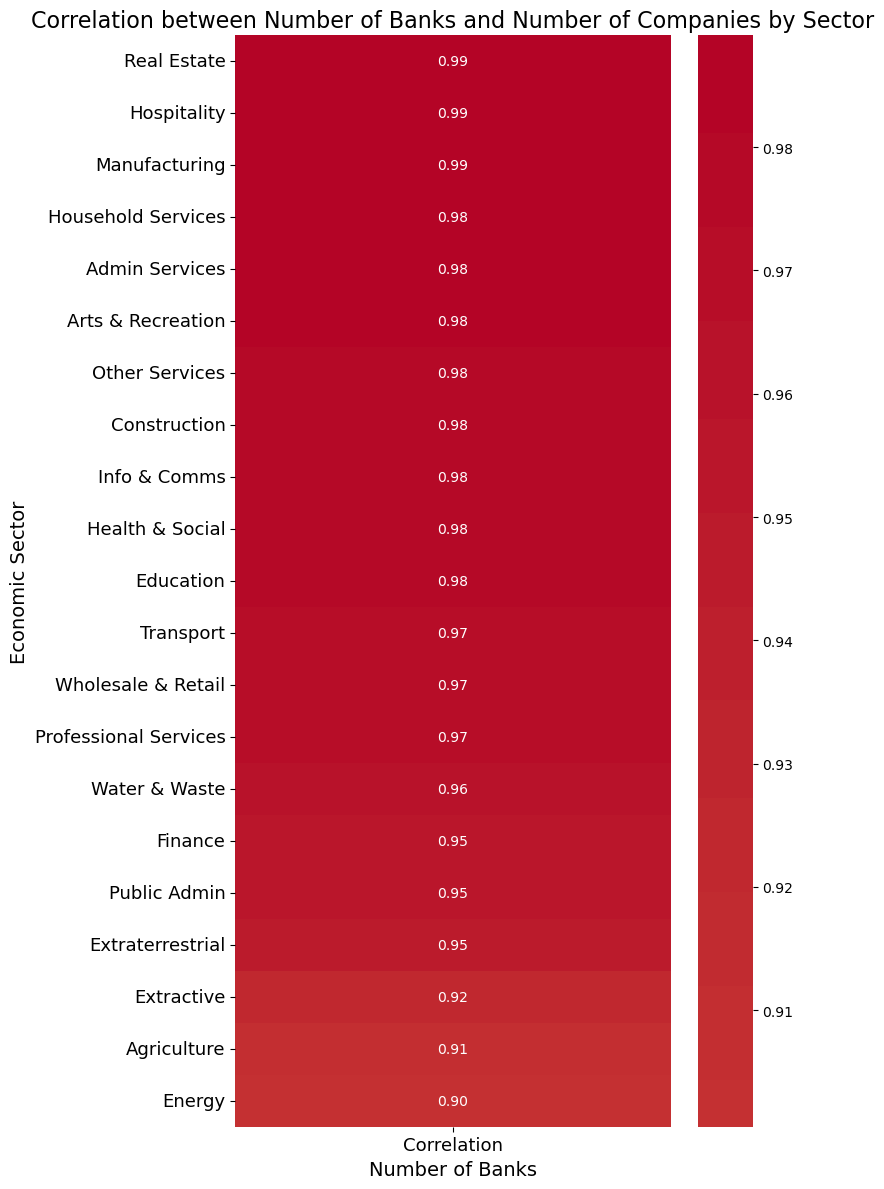

In [20]:
# Merge banks and companies data
banks_municip_final['municipality'] = banks_municip_final['municipality'].astype(str)
df_banks_companies = business_companies.merge(banks_municip_final, on='municipality', how='left')
df_banks_companies.fillna(0, inplace=True)

# Define relevant columns
bank_cols = ['banks_total']
sector_cols = [col for col in business_companies.columns if col != 'municipality']

# Calculate the correlation matrix
correlation_matrix = df_banks_companies[bank_cols + sector_cols].corr()

# Correlation between banks and economic sectors
correlation_table = correlation_matrix.loc[bank_cols, sector_cols]
correlation_table_sorted = correlation_table.T.sort_values(by='banks_total', ascending=False)

# Convert to DataFrame
correlation_df = correlation_table_sorted.reset_index()
correlation_df.columns = ['Sector', 'Correlation']

# Extract letters and apply clean names
correlation_df['Sector_letter'] = correlation_df['Sector'].str.extract(r'^([A-U])_')
correlation_df['Sector_clean'] = correlation_df['Sector_letter'].map(rename_dict)

# Plot
plt.figure(figsize=(8, 12))
sns.heatmap(
    correlation_df.set_index('Sector_clean')[['Correlation']],
    cmap='coolwarm', center=0, annot=True, fmt=".2f"
)
plt.title('Correlation between Number of Banks and Number of Companies by Sector', fontsize=16)
plt.ylabel('Economic Sector', fontsize=14)
plt.xlabel('Number of Banks', fontsize=14)
plt.xticks(rotation=0, fontsize=13)
plt.yticks(rotation=0, fontsize=13)
plt.tight_layout()
plt.show()

# Create a new DataFrame with columns: Sector and Correlation
correlation_df = correlation_df.drop(columns=['Sector', 'Sector_letter'])
correlation_df = correlation_df.rename(columns={'Sector_clean': 'Sector'})

2.2 Growth Rate of Companies by Economic Sector

C:\Users\Soledad.Acuna\AppData\Local\Temp\ipykernel_7092\1885086546.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='growth_rate', y='Sector_clean', data=growth_df_sorted, palette='viridis')


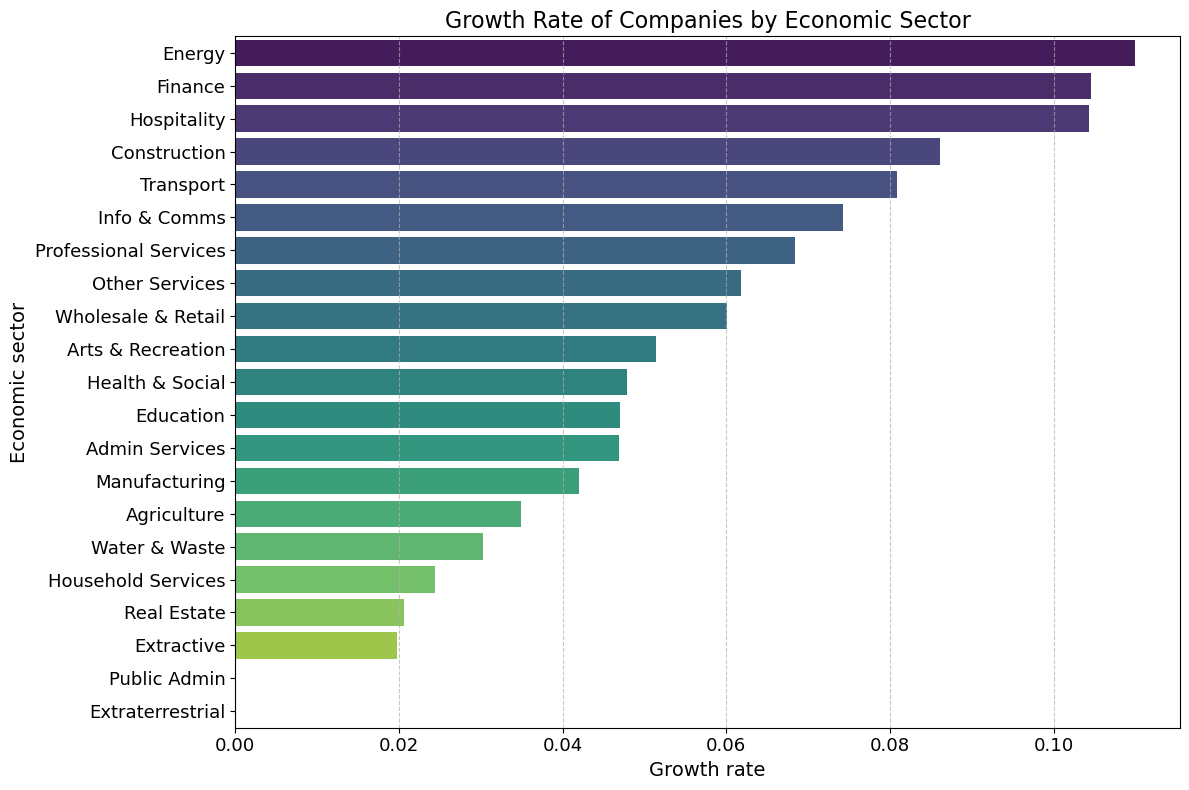

In [21]:
# Combine companies and new companies datasets 
business_combined = pd.concat([business_companies, business_new_companies.drop(columns='municipality')], axis=1)

# Add total companies and new companies per economic sector
total_companies_sector = business_combined.drop(columns='municipality').sum()

# Separate total and new companies
total_companies = total_companies_sector.iloc[0:21].reset_index()
new_companies = total_companies_sector.iloc[21:].reset_index()

# Extract sector letter (A–U)
sector_letters = [name.split('_')[0] for name in total_companies['index']]

# Create DataFrame
growth_df = pd.DataFrame({
    'Sector': sector_letters,
    'total_companies': total_companies[0].values,
    'new_companies': new_companies[0].values
})

# Calculate growth rate
growth_df['growth_rate'] = growth_df['new_companies'] / growth_df['total_companies']

# Add clean names
growth_df['Sector_clean'] = growth_df['Sector'].map(rename_dict)

# Sort 
growth_df_sorted = growth_df.sort_values(by='growth_rate', ascending=False)

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(x='growth_rate', y='Sector_clean', data=growth_df_sorted, palette='viridis')
plt.title('Growth Rate of Companies by Economic Sector', fontsize=16)
plt.xlabel('Growth rate', fontsize=14)
plt.ylabel('Economic sector', fontsize=14)
plt.xticks(rotation=0, fontsize=13)
plt.yticks(rotation=0, fontsize=13)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Create a new DataFrame with columns: Sector and growth_rate
growth_rate_df = growth_df_sorted[['Sector_clean', 'growth_rate']].reset_index(drop=True)
growth_rate_df = growth_rate_df.rename(columns={'Sector_clean': 'Sector'})


2.3. Number of Medium and Big Companies by Economic Sector

C:\Users\Soledad.Acuna\AppData\Local\Temp\ipykernel_7092\3325556326.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Total_Companies', y='Sector_clean', data=total_companies_sector, palette='viridis')


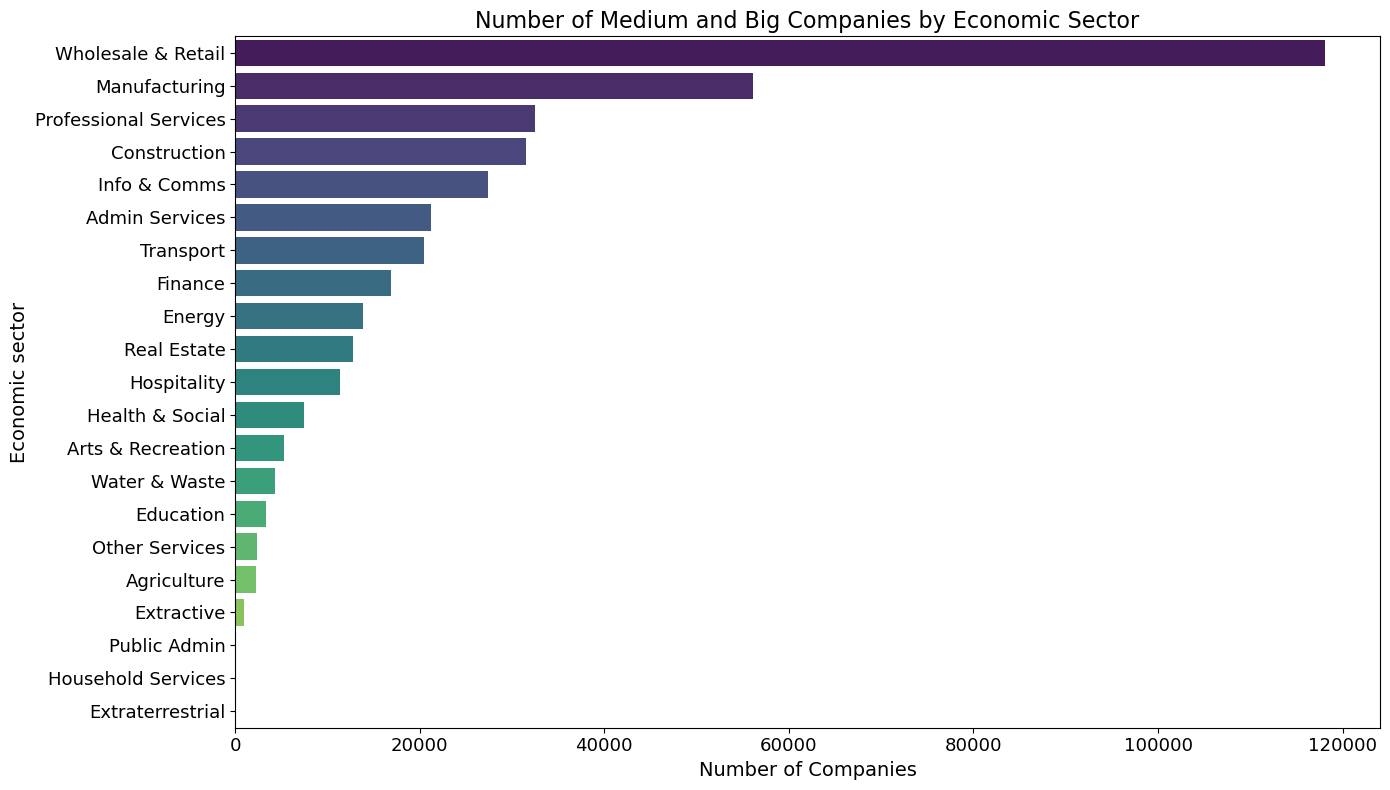

In [22]:
# Select columns of medium and large companies (billing > 5 million)
cols_ml = [col for col in business_billings.columns if 
           col.endswith('Between5000001And25000000_Billing') or
           col.endswith('Between25000001And50000000_Billing') or
           col.endswith('MoreThan50000000_Billing')]

# Subset with that columns
business_ml = business_billings[cols_ml]

# Group by sector letter
sums_by_letter = {}
for col in business_ml.columns:
    letter = col.split('_')[0]
    if letter not in sums_by_letter:
        sums_by_letter[letter] = business_ml[col]
    else:
        sums_by_letter[letter] += business_ml[col]

# Convert to DataFrame
df_sector_sums = pd.DataFrame(sums_by_letter)

# Total per economic sector
total_companies_sector = df_sector_sums.sum().reset_index()
total_companies_sector.columns = ['Sector', 'Total_Companies']

# Add missing sectors (T and U) with 0
missings = pd.DataFrame({
    'Sector': ['T', 'U'],
    'Total_Companies': [0, 0]
})
total_companies_sector = pd.concat([total_companies_sector, missings], ignore_index=True)

# Add clean names
total_companies_sector['Sector_clean'] = total_companies_sector['Sector'].map(rename_dict)

# Sort by number of companies
total_companies_sector = total_companies_sector.sort_values(by='Total_Companies', ascending=False)

# Plot
plt.figure(figsize=(14, 8))
sns.barplot(x='Total_Companies', y='Sector_clean', data=total_companies_sector, palette='viridis')
plt.title('Number of Medium and Big Companies by Economic Sector', fontsize=16)
plt.xlabel('Number of Companies', fontsize=14)
plt.ylabel('Economic sector', fontsize=14)
plt.xticks(rotation=0, fontsize=13)
plt.yticks(rotation=0, fontsize=13)
plt.tight_layout()
plt.show()

# Create a new DataFrame with columns: Sector and Total_Companies
total_companies_sector = total_companies_sector[['Sector_clean', 'Total_Companies']]
total_companies_sector = total_companies_sector.rename(columns={'Sector_clean': 'Sector'})


2.4. Number Companies with high profits by Economic Sector

C:\Users\Soledad.Acuna\AppData\Local\Temp\ipykernel_7092\1149281176.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Total_Companies_profit', y='Sector_clean', data=total_companies_sector_profit, palette='viridis')


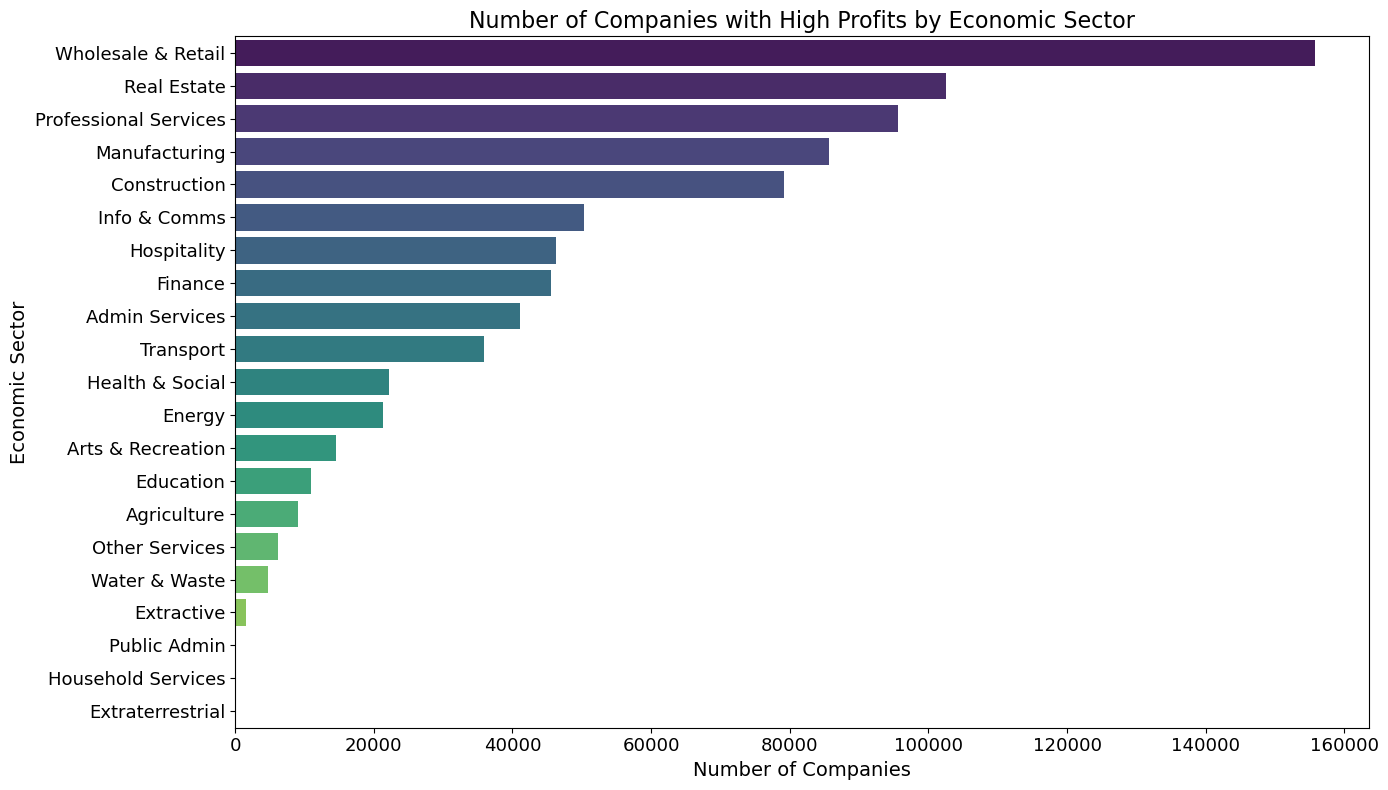

In [23]:
# Select columns of high profit companies (profit > 100,000)
cols_profit = [col for col in business_profit.columns if 
               col.endswith('Between100001And500000_Profit') or
               col.endswith('Between500001And1000000_Profit') or
               col.endswith('MoreThan1000000_Profit')]

# Subset with that columns
business_high_profit = business_profit[cols_profit]

# # Group by sector letter
sums_by_letter = {}
for col in business_high_profit.columns:
    letter = col.split('_')[0]
    if letter not in sums_by_letter:
        sums_by_letter[letter] = business_high_profit[col]
    else:
        sums_by_letter[letter] += business_high_profit[col]

# Convert to DataFrame
df_sector_sums = pd.DataFrame(sums_by_letter)

# Total per economic sector
total_companies_sector_profit = df_sector_sums.sum().reset_index()
total_companies_sector_profit.columns = ['Sector', 'Total_Companies_profit']

# Add clean names
total_companies_sector_profit['Sector_clean'] = total_companies_sector_profit['Sector'].map(rename_dict)

# Sort
total_companies_sector_profit = total_companies_sector_profit.sort_values(by='Total_Companies_profit', ascending=False)

# Plot
plt.figure(figsize=(14, 8))
sns.barplot(x='Total_Companies_profit', y='Sector_clean', data=total_companies_sector_profit, palette='viridis')
plt.title('Number of Companies with High Profits by Economic Sector', fontsize=16)
plt.xlabel('Number of Companies', fontsize=14)
plt.ylabel('Economic Sector', fontsize=14)
plt.xticks(rotation=0, fontsize=13)
plt.yticks(rotation=0, fontsize=13)
plt.tight_layout()
plt.show()

# Create a new DataFrame with columns: Sector and Total_Companies_profit
total_companies_sector_profit = total_companies_sector_profit[['Sector_clean', 'Total_Companies_profit']]
total_companies_sector_profit = total_companies_sector_profit.rename(columns={'Sector_clean': 'Sector'})


2.5. Ranking

C:\Users\Soledad.Acuna\AppData\Local\Temp\ipykernel_7092\236056951.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='mean_rank', y='Sector', data=ranking_df_sorted, palette='crest_r')


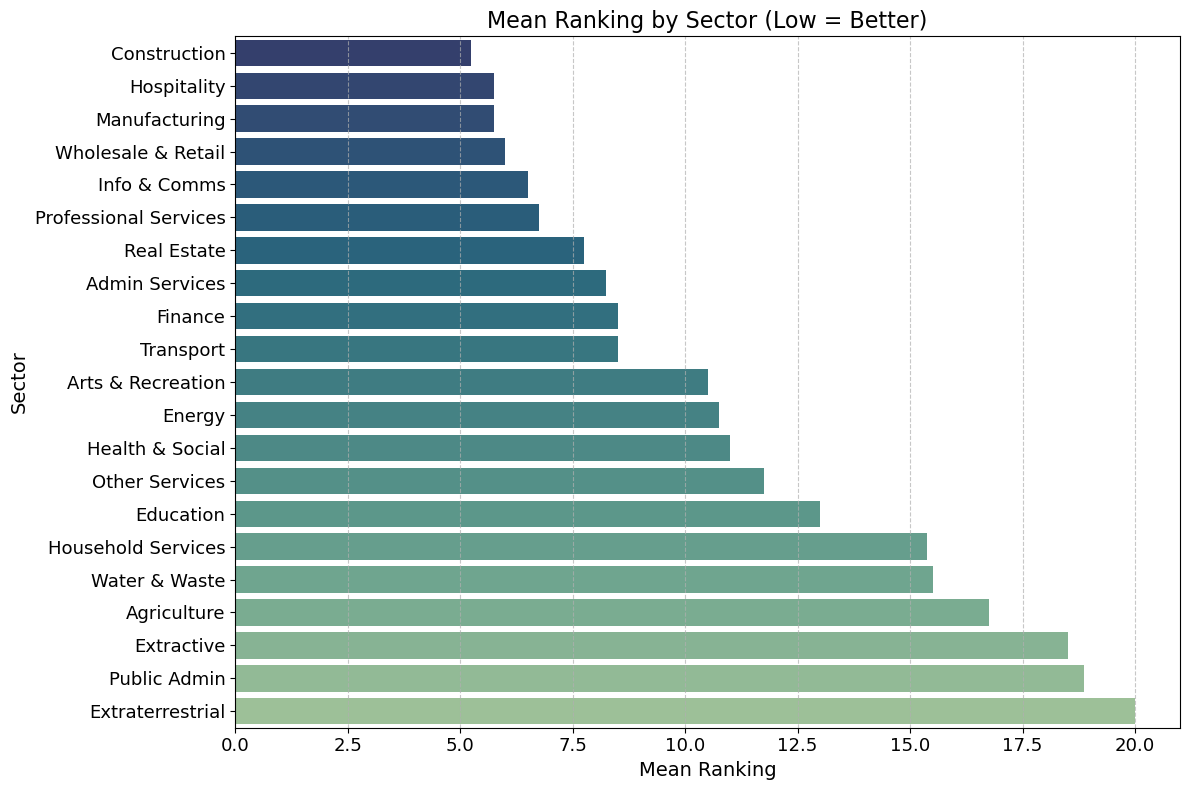

In [24]:
# Merge the DataFrames successively by the 'Sector' column
merged_df = correlation_df.merge(growth_rate_df, on='Sector', how='outer')
merged_df = merged_df.merge(total_companies_sector, on='Sector', how='outer')
merged_df = merged_df.merge(total_companies_sector_profit, on='Sector', how='outer')

# Create rankings (higher value = better ranking)
ranking_df = merged_df.copy()
ranking_df['rank_corr'] = ranking_df['Correlation'].rank(ascending=False)
ranking_df['rank_growth'] = ranking_df['growth_rate'].rank(ascending=False)
ranking_df['rank_size'] = ranking_df['Total_Companies'].rank(ascending=False)
ranking_df['rank_profit'] = ranking_df['Total_Companies_profit'].rank(ascending=False)

# Export the DataFrame c
df_rankings = ranking_df[['Sector', 'rank_corr', 'rank_growth', 'rank_size', 'rank_profit']]
df_rankings.to_csv('sector_rankings.csv', index=False)

# Calculate average ranking and sort
ranking_df['mean_rank'] = ranking_df[['rank_corr', 'rank_growth', 'rank_size', 'rank_profit']].mean(axis=1)
ranking_df_sorted = ranking_df.sort_values('mean_rank')

# Visualization
plt.figure(figsize=(12, 8))
sns.barplot(x='mean_rank', y='Sector', data=ranking_df_sorted, palette='crest_r')
plt.title('Mean Ranking by Sector (Low = Better)', fontsize=16)
plt.xlabel('Mean Ranking', fontsize=14)
plt.ylabel('Sector', fontsize=14)
plt.xticks(rotation=0, fontsize=13)
plt.yticks(rotation=0, fontsize=13)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()